In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Indlæs data

loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\13-month smoothed monthly total sunspot number 1-1749 to now.csv"
loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_polar2_fixed.csv"

column_names = ['Year', 'Year_fraction', 'Monthly_smoothed_sunspot_number', 'U1', 'U2', 'U3']
sunspot_raw_data = pd.read_csv(loc1, names=column_names, delimiter=';')
sunspot_raw_data = sunspot_raw_data.iloc[6:-6]

column_names = ['Date', 'North', 'South', 'Average', 'val4', 'colon', 'val5', 'val6', 'val7']
wso_raw_data = pd.read_csv(loc2, names=column_names, delimiter=',')

# Sunspot data
sunspot_date_fraction_arr = sunspot_raw_data['Year_fraction'].values.astype(float)
sunspot_number_arr = sunspot_raw_data['Monthly_smoothed_sunspot_number'].values.astype(float)

# WSO data
wso_date_arr = wso_raw_data['Date'].values
wso_north_arr = wso_raw_data['North'].values.astype(float)
wso_south_arr = wso_raw_data['South'].values.astype(float)
wso_average_arr = wso_raw_data['Average'].values.astype(float)

# Konverter til absolutværdi af gennemsnit
wso_average_arr = np.abs(wso_average_arr)

# Konverter datoer til brøkdele af år
wso_date_fraction_arr = np.zeros(len(wso_date_arr))
for i in range(len(wso_date_arr)):
    date = wso_date_arr[i]
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])
    wso_date_fraction_arr[i] = year + (30.4375 * (month - 1) + day) / 365.25

print(wso_date_fraction_arr)



[1976.41820671 1976.44404517 1976.47142368 ... 2024.00154004 2024.02737851
 2024.05475702]


In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Indlæs data

loc1 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_polar2_fixed.csv"

column_names = ['Date', 'North', 'South', 'Average', 'val4', 'colon', 'val5', 'val6', 'val7']
wso_raw_data = pd.read_csv(loc1, names=column_names, delimiter=',')

# WSO data
wso_date_arr = wso_raw_data['Date'].values
wso_north_arr = wso_raw_data['North'].values.astype(float)
wso_south_arr = wso_raw_data['South'].values.astype(float)
wso_average_arr = wso_raw_data['Average'].values.astype(float)

# Konverter til absolutværdi af gennemsnit
wso_average_arr = np.abs(wso_average_arr)



In [103]:
# Konverter datoer til brøkdele af år (ignorer dagen data blev taget på)
wso_date_fraction_arr = np.zeros(len(wso_date_arr))
for i in range(len(wso_date_arr)):
    date = wso_date_arr[i]
    year = int(date[:4])
    month = int(date[5:7])
    day = 1
    wso_date_fraction_arr[i] = year + (30.4375 * (month - 1) + day) / 365.25


# Lav et dictionary med formatet {fractional_date: [gennemsnit, gennemsnit, ...]} for alle gennemsnit med samme dato
wso_date_dict = {}
for i in range(len(wso_date_fraction_arr)):
    if wso_date_fraction_arr[i] in wso_date_dict:
        wso_date_dict[wso_date_fraction_arr[i]].append(wso_average_arr[i])
    else:
        wso_date_dict[wso_date_fraction_arr[i]] = [wso_average_arr[i]]



# Omregn til gennemsnit
for key, value in wso_date_dict.items():
    wso_date_dict[key] = np.mean(value)




### Rebinning til glidende gennemsnit

In [104]:
# 13 måneders glidende gennemsnit alle datapunkter vægtet med 1, første og sidste måned vægtet med 0.5
# Ingen data for de første 6 og sidste 6 måneder

# Returner [[glidende gennemsnit], [usikkerhed på glidende gennemsnit]]
def monthly_smoothed_13(data):
    smoothed_data = np.zeros(len(data))
    smoothed_data_uncert = np.zeros(len(data))
    for i in range(6, len(data) - 6):
        # Datapunkterne for de omkringliggende 12 måneder
        surrounding_data = data[i - 6:i + 7]
        # Beregn det glidende gennemsnit
        smoothed_data[i] = (0.5 * surrounding_data[0] + surrounding_data[1] + surrounding_data[2] + surrounding_data[3] + surrounding_data[4] + surrounding_data[5] + surrounding_data[6] + surrounding_data[7] + surrounding_data[8] + surrounding_data[9] + surrounding_data[10] + surrounding_data[11] + 0.5 * surrounding_data[12]) / 13
        # Beregn usikkerheden med formlen for usikkerheden på middelværdien
        smoothed_data_uncert[i] = np.std(surrounding_data) / np.sqrt(len(surrounding_data))

    # Slet de første og sidste 6 måneder
    smoothed_data = smoothed_data[6:-6]
    smoothed_data_uncert = smoothed_data_uncert[6:-6]

    return [smoothed_data, smoothed_data_uncert]


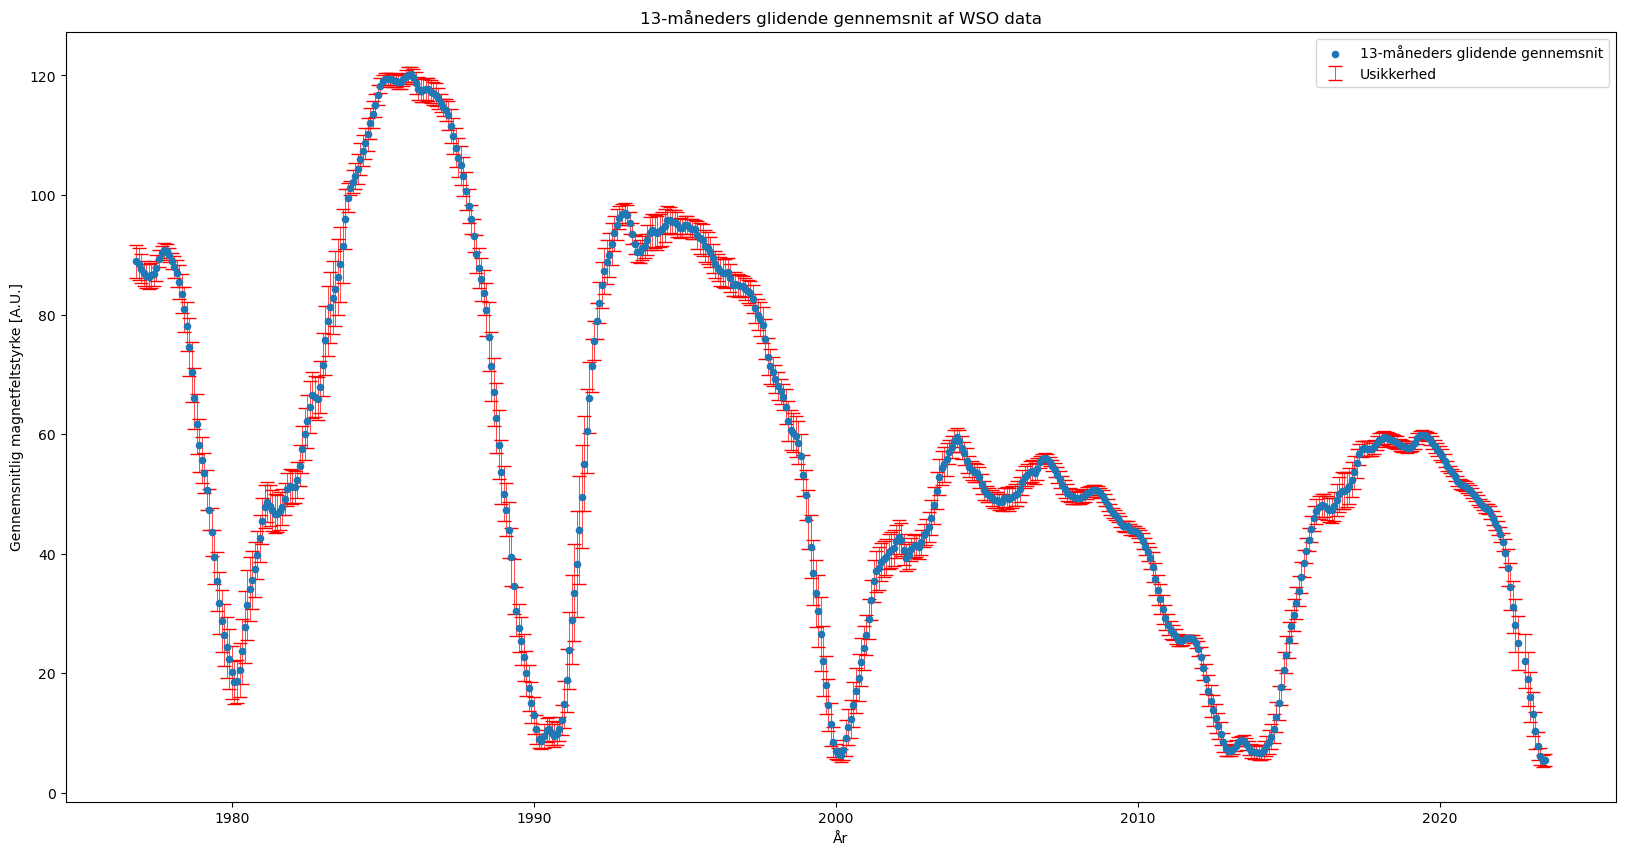

In [105]:
monthly_averaged_date, monthly_averaged_wso = zip(*(wso_date_dict.items()))

# 13-måneders glidende gennemsnit af magnetfeltsdata
monthly_smoothed_wso, monthly_smoothed_wso_uncert = monthly_smoothed_13(monthly_averaged_wso)

# Slet de første og sidste 6 måneder af datoer
monthly_averaged_date = monthly_averaged_date[6:-6]

# Plot data sammen med ikke smoothed data
ScatterSize = 20

plt.figure(figsize=(20,10))
#plt.scatter(wso_date_fraction_arr, wso_average_arr, label='Rå magnetfeltsdata', s=ScatterSize)
plt.scatter(monthly_averaged_date, monthly_smoothed_wso, label='13-måneders glidende gennemsnit', s=ScatterSize)
plt.errorbar(monthly_averaged_date, monthly_smoothed_wso, label="Usikkerhed", yerr=monthly_smoothed_wso_uncert, fmt='none', elinewidth=0.5, ecolor='red', capsize=5,  zorder=0)
plt.xlabel('År')
plt.ylabel('Gennemsnitlig magnetfeltstyrke [A.U.]')
plt.title('13-måneders glidende gennemsnit af WSO data')
plt.legend()
plt.show()



In [106]:
# Gem magnetfeltsdata i en fil
loc2 = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_smoothed.csv"
with open(loc2, 'w') as file:
    file.write('Dato (brøkdel), Magnetfeltsstyrke, Usikkerhed på magnetfeltsstyrke\n')
    for i in range(len(monthly_averaged_date)):
        file.write(str(monthly_averaged_date[i]) + ',' + str(monthly_smoothed_wso[i]) + ',' + str(monthly_smoothed_wso_uncert[i]) + '\n')
    file.close()



# Kopier dette felt for at importere data i anden fil

Husk at rette filstien til hvad end den er på din computer

Filen er datoer (i brøkdel af år) og absolutværdien af magnetfeltet (glidende 13-måneders gennemsnit)

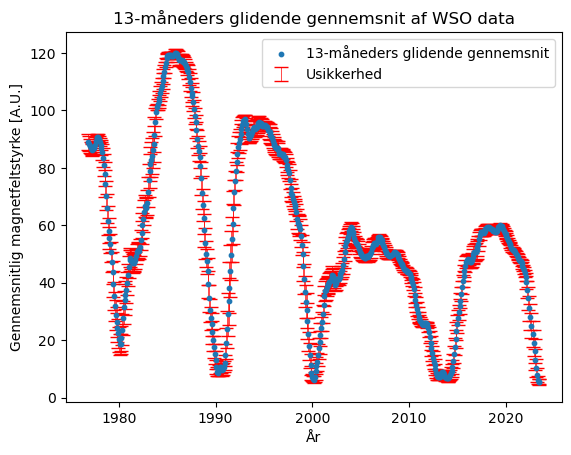

In [107]:
loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\Solpletter_projekt\Magnus carlsen\data\WSO_smoothed.csv"

column_names = ['Date', 'Magnetic_field', 'Uncertainty']
wso_smoothed_data = pd.read_csv(loc, names=column_names, delimiter=',', skiprows=1)
wso_smoothed_date_arr = wso_smoothed_data['Date'].values.astype(float)
wso_smoothed_magnetic_field_arr = wso_smoothed_data['Magnetic_field'].values.astype(float)
wso_smoothed_uncert_arr = wso_smoothed_data['Uncertainty'].values.astype(float)

# Plot
ScatterSize = 10

plt.scatter(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label='13-måneders glidende gennemsnit', s=ScatterSize)
plt.errorbar(wso_smoothed_date_arr, wso_smoothed_magnetic_field_arr, label="Usikkerhed", yerr=wso_smoothed_uncert_arr, fmt='none', elinewidth=0.5, ecolor='red', capsize=5,  zorder=0)
plt.xlabel('År')
plt.ylabel('Gennemsnitlig magnetfeltstyrke [A.U.]')
plt.title('13-måneders glidende gennemsnit af WSO data')
plt.legend()
plt.show()
